# Assignment 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy.spatial.distance import cdist

## Exercise 1: Particle Swarm Optimization

[730.3562005821021, 807.9150929576671, 829.0117583869608]
[[[-400. -400.]
  [-410. -410.]
  [-415. -415.]]

 [[-500. -500.]
  [-500. -500.]
  [-500. -500.]]] [ 730.35620058  807.91509296  829.01175839 -361.17831706 -361.17831706
 -361.17831706]


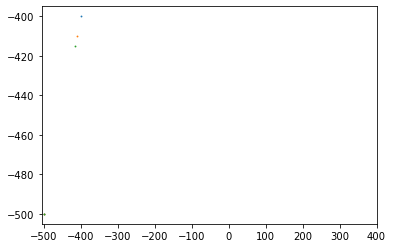

In [3]:
def f(x):
    return np.sum((-x) * np.sin(np.sqrt(np.abs(x))))

n = 3

xs = np.array([[-400, -400], [-410, -410], [-415, -415]]) # Positions
x_hat = xs.copy()      # Personal bests
g_hat = xs[2]          # Social best
a1 = a2 = 1                                  
r1 = r2 = 0.5
vels = np.array([[-50, -50]]*xs.shape[0])     # Velocities
w = 0.5                # Inertia


# Exercise 1a)

fitnesses = [f(x) for x in xs]
print(fitnesses)

# Exercise 1b)

def POS(xs, vels, x_hat, g_hat, w, a1, a2, r1, r2, it):
    next_xs = np.zeros((it+1, xs.shape[0], 2))
    next_xs[0] = xs
    
    for i in range(it):

        # Update velocities
        for j in range(n):
            vels[j] = w * vels[j] + a1*r2*(x_hat[j] - xs[j]) + a2*r2*(g_hat - xs[j])
        xs += vels
        
        fitnesses = [f(x) for x in xs]

        # Update local best
        for j in range(n):
            if fitnesses[j] > f(x_hat[j]):
                x_hat[j] = xs[j] 
        
        # Update global best
        if f(g_hat) < max(fitnesses):
            g_hat = xs[np.argmax(fitnesses)]

        next_xs[i+1] = xs
    
    # Constrain by limits
    next_xs = np.clip(next_xs, -500, 500) 
    return next_xs

xx = np.arange(-500, 500)

next_xs = POS(xs, vels, x_hat, g_hat, 2, a1, a2, r1, r2, 1)
fitnesses = np.array([f(x) for xs in next_xs for x in xs])



print(next_xs, fitnesses)
for i in range(next_xs.shape[1]):
    plt.scatter(next_xs[:,i,0], next_xs[:,i,1], s=0.7)
    # plt.plot(next_xs[:,i,0], next_xs[:,i,1])
    ticks = np.arange(-500, 500, 100)
    plt.xticks(ticks)


# res = [POS(xs, vels, x_hat, g_hat, w, a1, a2, r1, r2) for w in [2, 0.5, 0.1]]
# fitnesses = [fitness(x, r) for r in res for x in r]

# print(fitness(res[0], ))
# print(fitnesses)
# xx = np.array([[x,y] for x in range(-500,500) for y in range(-500, 500)])
# fx = np.array([f(x) for x in xx])
# plt.plot(xx, fx)
# print(max(fx))
# print(fitnesses)
# print(xs)
# print(xs)

## PSO K-Means

In [416]:
class Particle():
    def __init__(self, K, mn, mx, d, data):
        self.K = K
        self.centroids = np.array([r_pos(mn, mx, d, data) for _ in range(K)])
        self.pers_best = self.centroids.copy()
        self.velocity = np.array([np.random.uniform(-0.2, 0.2, d) for _ in range(K)])
        self.clusters = { k: [] for k in range(K)} # to assign datapoints to centroids
        self.distances = np.zeros(K)               # distance between each data point and centroid
        self.fit = 999999
        self.best_fit = 999999
    
    def fitness(self):
        return np.mean([self.distances[k]/len(self.clusters[k]) for k in range(self.K)])

    def reset(self):
        self.clusters = { k: [] for k in range(self.K)}
        self.distances = np.zeros(self.K)

def r_pos(mn, mx, D, data):
    return np.random.uniform(-2, 2, D) + np.array([np.mean(data[:,i]) for i in range(D)])

def distance(v1, v2):
    if len(v1.shape) == 1 and len(v2.shape) == 1:
        return np.sqrt(np.sum((v2 - v1)**2, dtype=np.float64))
    else:
        return np.sqrt(np.sum((v2 - v1)**2, axis=1, dtype=np.float64))
              
def KMeans_PSO(K, N, T, data, w, a1, a2, r1, r2):
    mn, mx = np.amin(data), np.amax(data)
    D = data.shape[1]

    # Initial list of N particles, each containing K centroids
    particles = np.array([Particle(K, mn, mx, D, data) for _ in range(N)])

    # Initialise global best
    g_best = particles[0].centroids.copy()
    g_fit = particles[0].fit

    for _ in range(T):
        for p in particles:
            p.reset()
            for d in data:
                
                # Calculate the distance of each data-point to each centroid of the particle
                dist = np.array([distance(c, d) for c in p.centroids])
                
                # Assign the data-point to a centroid
                p.clusters[dist.argmin()].append(d)

                # Sum the distance to the centroid
                p.distances[dist.argmin()] += np.min(dist)

            # Evaluate the particle
            p.fit = p.fitness()

            # Update the personal best
            if p.best_fit > p.fit:
                p.pers_best = p.centroids.copy()
                p.best_fit = p.fit

        # Update the global best
        fits = [p.best_fit for p in particles]
        if g_fit > min(fits):
            g_fit = min(fits)
            g_best = particles[np.argmin(fits)].centroids.copy()
            
        
        # Update each particle
        for p in particles:
            r1 = np.random.uniform(0, 1, p.centroids.shape)
            r2 = np.random.uniform(0, 1, p.centroids.shape)
            p.velocity = w*p.velocity + a1*r1*(g_best - p.centroids) + a2*r2*(p.pers_best - p.centroids)
            p.centroids += p.velocity
        
    return g_best, g_fit


def K_means(data, K, T):
    
    # Initialise K centroids
    centroids = np.array([r_pos(1,1, data.shape[1], data) for _ in range(K)])

    fits = []
    for _ in range(T):
        
        # Initialise dict to assign data to centroids
        clusters = { k: [] for k in range(K)}
        
        for d in data:

            # Calculate distances to centroids 
            dists = np.array(distance(d, centroids))

            # Assign data-point to centroid
            clusters[np.argmin(dists)].append(d)

        # Adjust centroids
        centroids = np.array([centroids[i] if len(c) == 0 else np.mean(c, axis=0) for i, c in clusters.items()])
        
        # Quantization error
        total = []
        for i, v in clusters.items():
            if len(v) == 0:
                v.append(r_pos(0, 0, data.shape[1]))
            s = []
            for e in v:
                d = distance(e, centroids[i])
                s.append(d)
            total.append(np.mean(s))
        q_error = np.mean(total)

    return centroids, q_error

# def quantization_error(centroids, data):
#     n_clusters = centroids.shape[0]
#     distances = np.sqrt(np.square(data - centroids[:, None]).sum(axis=2)).T
#     clustering = np.argmin(distances,1)
#     means = np.zeros((n_clusters,))
#     for i in range(n_clusters):
#         means[i] = np.mean(distances[clustering == i])
#     return np.mean(means)

### Some toy example

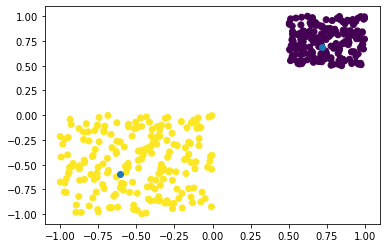

Quantization error: 0.296631953390467


In [223]:
# Creating data
N_d = 400
data = np.array([r_pos(-1, 0, 2) if i < N_d/2 else r_pos(0.5, 1, 2) for i in range(N_d)])
labels = [1 if d[0] < 0.5 else 0 for d in data]
plt.scatter(data[:,0], data[:,1], label='data', c=labels)

# Parameters
N = 10  # N particles
K = 2   # K centroids
T = 10  # Time horizon
w = 0.7298 # Inertia
a1 = a2 = 1.49618 # Scale parameter
r1 = r2 = 0.5 # Random parameter


# KMeans
# centroids, q_error = K_means(data, K, 10) 

# KMeans PSO
centroids, q_error = KMeans_PSO(K, N, T, data, w, a1, a2, r1, r2)

# Plot
plt.scatter(centroids[:,0], centroids[:,1], label='centroids')
plt.show()
print(f'Quantization error: {q_error}')

### Artificial Problem 1

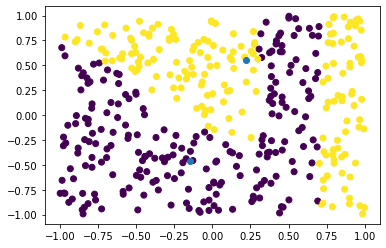

Quantization error: 0.5912766136274126


In [224]:
# Creating data
N_d = 400
data = np.array([r_pos(-1, 1, 2) for _ in range(N_d)])
labels = [1 if d[0] >= 0.7 or (d[0] <= 0.3 and d[1] >= -0.2-d[0]) else 0 for d in data]
plt.scatter(data[:,0], data[:,1], label='data', c=labels)

# Parameters
N = 10  # N particles
K = 2   # K centroids
T = 10  # Time horizon
w = 0.7298 # Inertia
a1 = a2 = 1.49618 # Scale parameter
r1 = r2 = 0.5 # Random parameter

# KMeans
# centroids, q_error = K_means(data, K, T)

# KMeans PSO
centroids, q_error = KMeans_PSO(K, N, T, data, w, a1, a2, r1, r2)

# Plot
plt.scatter(centroids[:,0], centroids[:,1], label='centroids')
plt.show()
print(f'Quantization error: {q_error}')

### Iris dataset

No handles with labels found to put in legend.


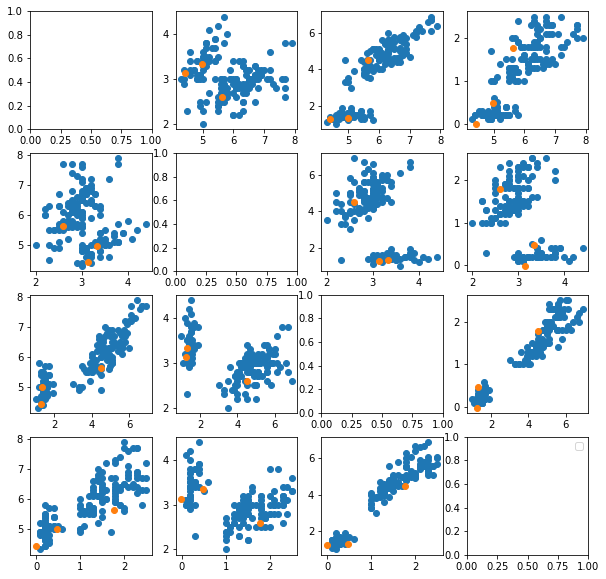

Quantization error: 0.7447258591323979


In [418]:
# Iris data
iris = pd.read_csv('iris.data', header=0, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])
labels = iris.values[:,-1]
data = iris.values[:,:-1]

# Parameters
N = 100  # N particles
K = len(np.unique(labels))   # K centroids
T = 10  # Time horizon
w = 0.7298 # Inertia
a1 = a2 = 1.49618 # Scale parameter
r1 = r2 = 0.5 # Random parameter

# KMeans
# centroids, q_error = K_means(data, K, T)

# KMeans PSO
centroids, q_error = KMeans_PSO(K, N, T, data, w, a1, a2, r1, r2)

# Plot
fig, ax = plt.subplots(4, 4, figsize=((10, 10)))

for i in range(4):
    for j in range(4):
        if i != j:
            ax[i, j].scatter(data[:,i], data[:,j], label='data')
            ax[i, j].scatter(centroids[:,i], centroids[:,j], label='centroids')
plt.legend()
plt.show()
print(f'Quantization error: {q_error}')